# Install these librarires if you havent already

In [ ]:
%pip install -r requirements.txt

In [1]:
import sys
import pandas as pd

try:
    df = pd.read_excel("Stocks.xlsx", sheet_name="Stocks", skiprows=1)
except FileNotFoundError:
    print("The file cannot be found!")
    sys.exit()

df.columns = [
"วันที่", "ราคาเปิด", "ราคาสูงสุด", "ราคาต ่าสุด", "ราคาเฉลี่ย", "ราคาปิด",
"เปลี่ยนแปลง", "เปลี่ยนแปลง(%)", "ปริมาณ(พันหุ้น)", "มูลค่า(ล้านบาท)",
"SET Index", "SET เปลี่ยนแปลง(%)"
]
thai_months = {
"ม.ค.": "01", "ก.พ.": "02", "มี.ค.": "03", "เม.ย.": "04",
"พ.ค.": "05", "มิ.ย.": "06", "ก.ค.": "07", "ส.ค.": "08",
"ก.ย.": "09", "ต.ค.": "10", "พ.ย.": "11", "ธ.ค.": "12"
}
def convert_thai_date(thai_date_str):
    for th, num in thai_months.items():
        if th in thai_date_str:
            day, month_th, year_th = thai_date_str.replace(",", "").split()
            month = thai_months[month_th]
            year = int(year_th) - 543
            return f"{year}-{month}-{int(day):02d}"
    return None

df = df[~df["วันที่"].isna() & ~df["วันที่"].str.contains("วันที่")]
df["วันที่"] = df["วันที่"].apply(convert_thai_date)
df["วันที่"] = pd.to_datetime(df["วันที่"])
df = df.dropna()
df.head(5)

,วันที่,ราคาเปิด,ราคาสูงสุด,ราคาต ่าสุด,ราคาเฉลี่ย,ราคาปิด,เปลี่ยนแปลง,เปลี่ยนแปลง(%),ปริมาณ(พันหุ้น),มูลค่า(ล้านบาท),SET Index,SET เปลี่ยนแปลง(%)
1,2025-05-23,34.5,34.5,33.75,34.13,34,-0.25,-0.73,12024.42,410.39,1176.36,0.25
2,2025-05-22,34,34.75,34,34.33,34.25,0.25,0.74,21168.47,726.66,1173.37,-0.55
3,2025-05-21,34.75,35,33.25,33.99,34,-0.75,-2.16,35492.29,1206.51,1179.81,-0.78
4,2025-05-20,35.5,35.5,34.5,34.85,34.75,-0.5,-1.42,16071.32,560.13,1189.14,0.18
5,2025-05-19,34.5,35.75,34.5,35.03,35.25,0.5,1.44,32789.51,1148.75,1187.06,-0.73


In [2]:
print(df["ราคาปิด"].describe())
print(df[df["ราคาปิด"] == df["ราคาปิด"].max()])
print(df[["ราคาปิด", "SET Index"]].corr())


count     119.00
unique     61.00
top        59.75
freq        5.00
Name: ราคาปิด, dtype: float64
        วันที่ ราคาเปิด ราคาสูงสุด ราคาต ่าสุด ราคาเฉลี่ย ราคาปิด เปลี่ยนแปลง  \
113 2024-12-03    61.75         62       61.25      61.74      62        0.25   

    เปลี่ยนแปลง(%) ปริมาณ(พันหุ้น) มูลค่า(ล้านบาท) SET Index  \
113            0.4        13052.88          805.83   1454.76   

    SET เปลี่ยนแปลง(%)  
113               1.23  
            ราคาปิด  SET Index
ราคาปิด    1.000000   0.956706
SET Index  0.956706   1.000000


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


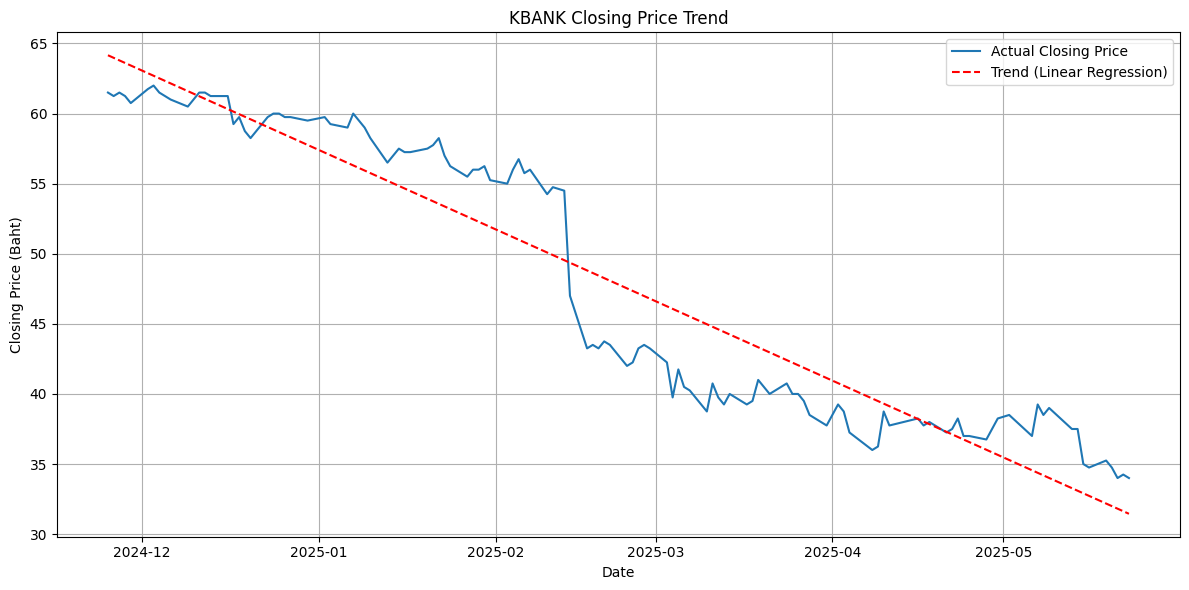

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.family'] = 'DejaVu Sans'
df_sorted = df.sort_values("วันที่")
X = df_sorted["วันที่"].map(pd.Timestamp.toordinal).to_numpy().reshape(-1, 1)
y = df_sorted["ราคาปิด"].astype(float).to_numpy()

model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)

plt.figure(figsize=(12, 6))
plt.plot(df_sorted["วันที่"], y, label="Actual Closing Price")
plt.plot(df_sorted["วันที่"], trend, label="Trend (Linear Regression)", linestyle="--", color="red")
plt.title("KBANK Closing Price Trend")
plt.xlabel("Date")
plt.ylabel("Closing Price (Baht)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save the plot as an image
plt.savefig("kbank_closing_price_trend.png")

# Save the data (date, actual, trend) to CSV
output_df = pd.DataFrame({
    "วันที่": df_sorted["วันที่"].dt.strftime("%Y-%m-%d"),
    "ราคาปิด": y,
    "แนวโน้ม": trend
})
output_df.to_csv("kbank_closing_price_trend.csv", index=False)